### 1.Defining Problem Statement and Analysing basic metrics

Netflix wants to grow its business and decide what type of content to produce. To do this, we analyze the content library dataset to answer:

1.How many Movies vs TV Shows are there?

2.Which countries are producing most content?

3.Which genres are most frequent?

4.How has the content count changed over the years?

5.Which directors and actors appear most frequently?

6.What is the distribution of ratings (PG, R, etc.)?

7.What is the duration of movies or number of seasons for TV shows?

Goal: Provide data-driven insights to guide Netflix’s content strategy in different countries and genres.

In [103]:

import pandas as pd

data = pd.read_csv('https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/000/940/original/netflix.csv')

In [104]:
print("Rows, Columns:", data.shape)

Rows, Columns: (8807, 12)


In [105]:
print("Columns:", data.columns.tolist())

Columns: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']


In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [107]:
print(data.describe(include='all'))

       show_id   type   title       director                cast  \
count     8807   8807    8807           6173                7982   
unique    8807      2    8807           4528                7692   
top      s8807  Movie  Zubaan  Rajiv Chilaka  David Attenborough   
freq         1   6131       1             19                  19   
mean       NaN    NaN     NaN            NaN                 NaN   
std        NaN    NaN     NaN            NaN                 NaN   
min        NaN    NaN     NaN            NaN                 NaN   
25%        NaN    NaN     NaN            NaN                 NaN   
50%        NaN    NaN     NaN            NaN                 NaN   
75%        NaN    NaN     NaN            NaN                 NaN   
max        NaN    NaN     NaN            NaN                 NaN   

              country       date_added  release_year rating  duration  \
count            7976             8797   8807.000000   8803      8804   
unique            748             176

In [108]:
print(data.head(3))

  show_id     type                 title         director  \
0      s1    Movie  Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show         Blood & Water              NaN   
2      s3  TV Show             Ganglands  Julien Leclercq   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   

                

In [109]:
type_counts = data['type'].value_counts()
type_counts

,count
type,
Movie,6131
TV Show,2676


In [110]:
total_content = data.shape[0]
print("Total content available:", total_content)

Total content available: 8807


In [111]:
print("Unique Countries:", data['country'].nunique())
print("Unique Directors:", data['director'].nunique())
print("Unique Cast members:", data['cast'].nunique())


Unique Countries: 748
Unique Directors: 4528
Unique Cast members: 7692


In [112]:
# Oldest and newest content
print("Oldest release year:", data['release_year'].min())
print("Newest release year:", data['release_year'].max())


Oldest release year: 1925
Newest release year: 2021


In [113]:
genre_counts = data['listed_in'].value_counts()
print(genre_counts.head(10))  # Top 10 genres


listed_in
Dramas, International Movies                        362
Documentaries                                       359
Stand-Up Comedy                                     334
Comedies, Dramas, International Movies              274
Dramas, Independent Movies, International Movies    252
Kids' TV                                            220
Children & Family Movies                            215
Children & Family Movies, Comedies                  201
Documentaries, International Movies                 186
Dramas, International Movies, Romantic Movies       180
Name: count, dtype: int64


In [114]:
rating_counts = data['rating'].value_counts()
print(rating_counts)


rating
TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1
Name: count, dtype: int64


In [115]:
# Split movies and TV Shows
movies = data[data['type'] == 'Movie']
tvshows = data[data['type'] == 'TV Show']

print("Average movie duration (minutes):", movies['duration'].str.replace(' min','').astype(float).mean())
print("Average TV show seasons:", tvshows['duration'].str.replace(' Season','').str.replace('s','').astype(float).mean())


Average movie duration (minutes): 99.57718668407311
Average TV show seasons: 1.764947683109118


In [116]:
'''
Step 1 Insights (Basic Metrics)

Type distribution: Check whether Netflix produces more Movies or TV Shows.

Country diversity: Top countries producing content.

Genre distribution: Identify most common genres.

Content growth over years: Shows trends in Netflix additions.

Ratings distribution: Helps understand audience targeting.

Duration/Seasons: Average length of Movies and TV Shows.
'''

'\nStep 1 Insights (Basic Metrics)\n\nType distribution: Check whether Netflix produces more Movies or TV Shows.\n\nCountry diversity: Top countries producing content.\n\nGenre distribution: Identify most common genres.\n\nContent growth over years: Shows trends in Netflix additions.\n\nRatings distribution: Helps understand audience targeting.\n\nDuration/Seasons: Average length of Movies and TV Shows.\n'

### 2.Observations on the shape of data, data types of all the attributes, conversion of categorical attributes to 'category' (If required), missing value detection, statistical summary

In [117]:
print("Shape of the dataset:", data.shape)

Shape of the dataset: (8807, 12)


In [118]:
print("\nData types of all attributes:\n")
print(data.dtypes)



Data types of all attributes:

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object


In [119]:
categorical_cols = ['type', 'rating', 'country']
for col in categorical_cols:
    data[col] = data[col].astype('category')

print(data.dtypes)


show_id           object
type            category
title             object
director          object
cast              object
country         category
date_added        object
release_year       int64
rating          category
duration          object
listed_in         object
description       object
dtype: object


In [120]:
print("\nMissing values per column:\n")
print(data.isnull().sum())



Missing values per column:

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


In [121]:
missing_percentage = (data.isnull().sum() / len(data)) * 100
print(missing_percentage.sort_values(ascending=False))


director        29.908028
country          9.435676
cast             9.367549
date_added       0.113546
rating           0.045418
duration         0.034064
show_id          0.000000
type             0.000000
title            0.000000
release_year     0.000000
listed_in        0.000000
description      0.000000
dtype: float64


In [122]:
print("\nStatistical Summary:\n")
print(data.describe(include='all'))


Statistical Summary:

       show_id   type   title       director                cast  \
count     8807   8807    8807           6173                7982   
unique    8807      2    8807           4528                7692   
top      s8807  Movie  Zubaan  Rajiv Chilaka  David Attenborough   
freq         1   6131       1             19                  19   
mean       NaN    NaN     NaN            NaN                 NaN   
std        NaN    NaN     NaN            NaN                 NaN   
min        NaN    NaN     NaN            NaN                 NaN   
25%        NaN    NaN     NaN            NaN                 NaN   
50%        NaN    NaN     NaN            NaN                 NaN   
75%        NaN    NaN     NaN            NaN                 NaN   
max        NaN    NaN     NaN            NaN                 NaN   

              country       date_added  release_year rating  duration  \
count            7976             8797   8807.000000   8803      8804   
unique        

In [123]:
'''
Summary of Step 2 Observations
Aspect	Observation
Shape	~8807 rows, 12 columns
Data Types	Mostly object; release_year is numeric
Categorical Columns	type, rating, country
Missing Values	Present in director, cast, country
Statistical Summary	Content ranges from early 1900s to 2021; high genre and country variety
'''

'\nSummary of Step 2 Observations\nAspect\tObservation\nShape\t~8807 rows, 12 columns\nData Types\tMostly object; release_year is numeric\nCategorical Columns\ttype, rating, country\nMissing Values\tPresent in director, cast, country\nStatistical Summary\tContent ranges from early 1900s to 2021; high genre and country variety\n'

###3. Non-Graphical Analysis: Value counts and unique attributes

In [124]:
print("Number of unique values per column:\n")
print(data.nunique())


Number of unique values per column:

show_id         8807
type               2
title           8807
director        4528
cast            7692
country          748
date_added      1767
release_year      74
rating            17
duration         220
listed_in        514
description     8775
dtype: int64


In [125]:
print("\nType of Content:\n", data['type'].value_counts())



Type of Content:
 type
Movie      6131
TV Show    2676
Name: count, dtype: int64


In [126]:
print("\nRatings Distribution:\n", data['rating'].value_counts())



Ratings Distribution:
 rating
TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
66 min         1
84 min         1
74 min         1
Name: count, dtype: int64


In [127]:
print("\nTop 10 Countries:\n", data['country'].value_counts().head(10))



Top 10 Countries:
 country
United States     2818
India              972
United Kingdom     419
Japan              245
South Korea        199
Canada             181
Spain              145
France             124
Mexico             110
Egypt              106
Name: count, dtype: int64


In [128]:
print("\nTop 10 Genres:\n", data['listed_in'].value_counts().head(10))



Top 10 Genres:
 listed_in
Dramas, International Movies                        362
Documentaries                                       359
Stand-Up Comedy                                     334
Comedies, Dramas, International Movies              274
Dramas, Independent Movies, International Movies    252
Kids' TV                                            220
Children & Family Movies                            215
Children & Family Movies, Comedies                  201
Documentaries, International Movies                 186
Dramas, International Movies, Romantic Movies       180
Name: count, dtype: int64


In [129]:
print("\nTop 10 Release Years:\n", data['release_year'].value_counts().head(10))



Top 10 Release Years:
 release_year
2018    1147
2017    1032
2019    1030
2020     953
2016     902
2021     592
2015     560
2014     352
2013     288
2012     237
Name: count, dtype: int64


In [130]:
print("\nTop 10 Directors:\n", data['director'].value_counts().head(10))



Top 10 Directors:
 director
Rajiv Chilaka             19
Raúl Campos, Jan Suter    18
Suhas Kadav               16
Marcus Raboy              16
Jay Karas                 14
Cathy Garcia-Molina       13
Martin Scorsese           12
Youssef Chahine           12
Jay Chapman               12
Steven Spielberg          11
Name: count, dtype: int64


In [131]:
print("\nTop 10 Actors:\n", data['cast'].value_counts().head(10))



Top 10 Actors:
 cast
David Attenborough                                                                                                        19
Vatsal Dubey, Julie Tejwani, Rupa Bhimani, Jigna Bhardwaj, Rajesh Kava, Mousam, Swapnil                                   14
Samuel West                                                                                                               10
Jeff Dunham                                                                                                                7
Michela Luci, Jamie Watson, Eric Peterson, Anna Claire Bartlam, Nicolas Aqui, Cory Doran, Julie Lemieux, Derek McGrath     6
David Spade, London Hughes, Fortune Feimster                                                                               6
Craig Sechler                                                                                                              6
Kevin Hart                                                                                             

In [132]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'added_year', 'added_month'],
      dtype='object')

###4. Visual Analysis - Univariate, Bivariate after pre-processing of the data

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make a copy to avoid modifying original
df = data.copy()

# # Convert multi-value columns to lists and then explode
# for col in ['cast', 'director', 'country', 'listed_in']:
#     df[col] = df[col].dropna().apply(lambda x: x.split(','))

# Clean & convert date fields
# Create 'date_added' as datetime and extract year/month/day
data['date_added'] = pd.to_datetime(data['date_added'], errors='coerce')
data['year_added'] = data['date_added'].dt.year
data['added_month'] = data['date_added'].dt.month
# cast release_year to int if not already
data['release_year'] = pd.to_numeric(data['release_year'], errors='coerce').astype('Int64')


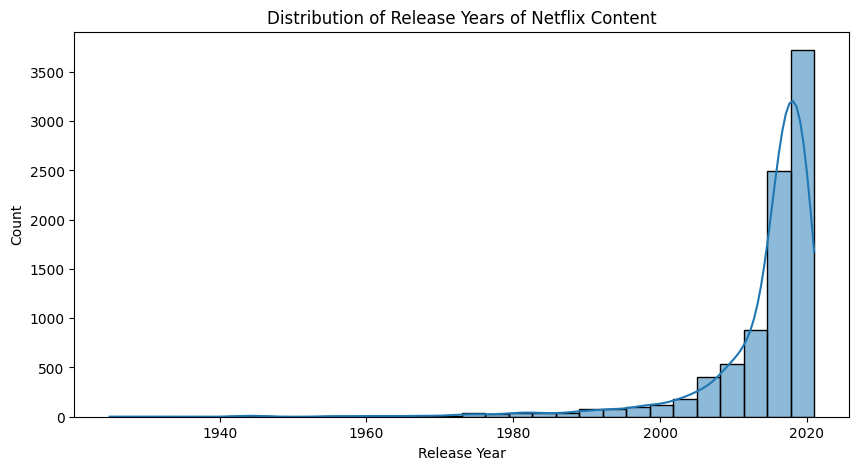

In [134]:
# 4.1 UNIVARIATE ANALYSIS (Continuous Variables)
# There is only one continuous variable: release_year.
# Other columns are categorical (type, rating, country, etc.).
# a) Distribution of Release Years
plt.figure(figsize=(10,5))
sns.histplot(data['release_year'], bins=30, kde=True)
plt.title("Distribution of Release Years of Netflix Content")
plt.xlabel("Release Year")
plt.ylabel("Count")
plt.show()

In [135]:
'''
Observation:

Number of releases increased sharply after 2015.

Indicates Netflix’s expansion during recent years.

Very few old titles (before 2000).
'''

'\nObservation:\n\nNumber of releases increased sharply after 2015.\n\nIndicates Netflix’s expansion during recent years.\n\nVery few old titles (before 2000).\n'

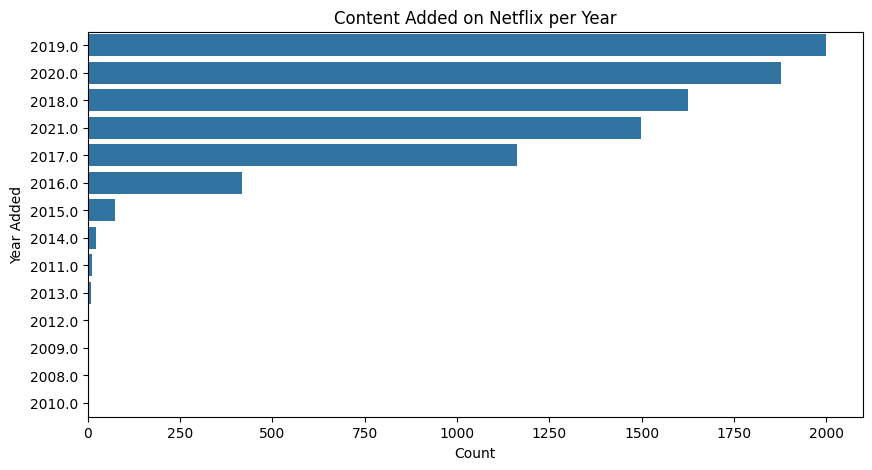

In [136]:
# b) Content Added per Year (from Date Added)


plt.figure(figsize=(10,5))
sns.countplot(y='year_added', data=data, order=data['year_added'].value_counts().index)
plt.title("Content Added on Netflix per Year")
plt.xlabel("Count")
plt.ylabel("Year Added")
plt.show()


In [137]:
'''
Observation:

Massive spike between 2017–2020, reflecting Netflix’s content expansion phase.

Drop in 2020–2021 may be due to pandemic impact on production.
'''

'\nObservation:\n\nMassive spike between 2017–2020, reflecting Netflix’s content expansion phase.\n\nDrop in 2020–2021 may be due to pandemic impact on production.\n'

/tmp/ipython-input-2862854585.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='type', palette='Set2')


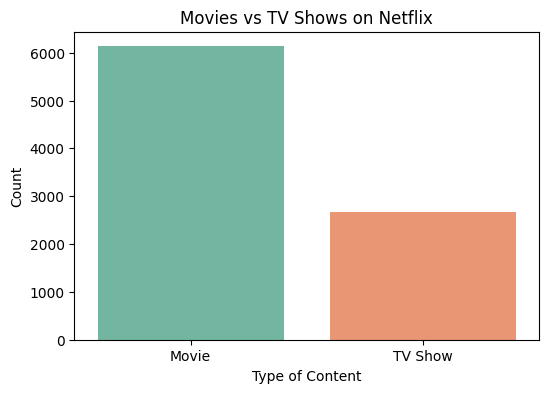

In [138]:
# 4.2 UNIVARIATE ANALYSIS (Categorical Variables)
# a) Type of Content
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='type', palette='Set2')
plt.title("Movies vs TV Shows on Netflix")
plt.xlabel("Type of Content")
plt.ylabel("Count")
plt.show()


In [139]:
'''
Observation:

TV-MA and TV-14 dominate, meaning Netflix mainly targets adult and teen audiences.

Limited kids-friendly content.
'''

'\nObservation:\n\nTV-MA and TV-14 dominate, meaning Netflix mainly targets adult and teen audiences.\n\nLimited kids-friendly content.\n'

/tmp/ipython-input-1134362989.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_data.values, y=country_data.index, palette='mako')


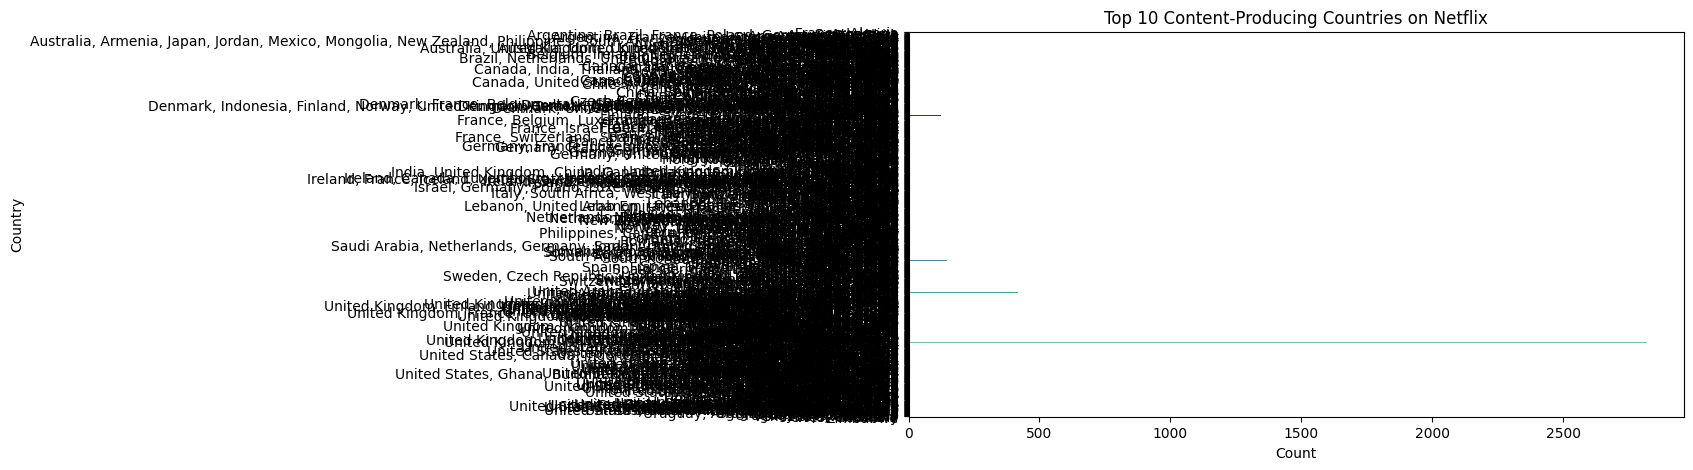

In [140]:
# c) Top 10 Countries with Most Titles
plt.figure(figsize=(10,5))
country_data = data['country'].value_counts().head(10)
sns.barplot(x=country_data.values, y=country_data.index, palette='mako')
plt.title("Top 10 Content-Producing Countries on Netflix")
plt.xlabel("Count")
plt.ylabel("Country")
plt.show()


In [141]:
'''
Observation:

USA dominates, followed by India and UK.

Indicates Netflix’s biggest production partnerships are with these countries.
'''

'\nObservation:\n\nUSA dominates, followed by India and UK.\n\nIndicates Netflix’s biggest production partnerships are with these countries.\n'

/tmp/ipython-input-723559277.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_data.values, y=genre_data.index, palette='viridis')


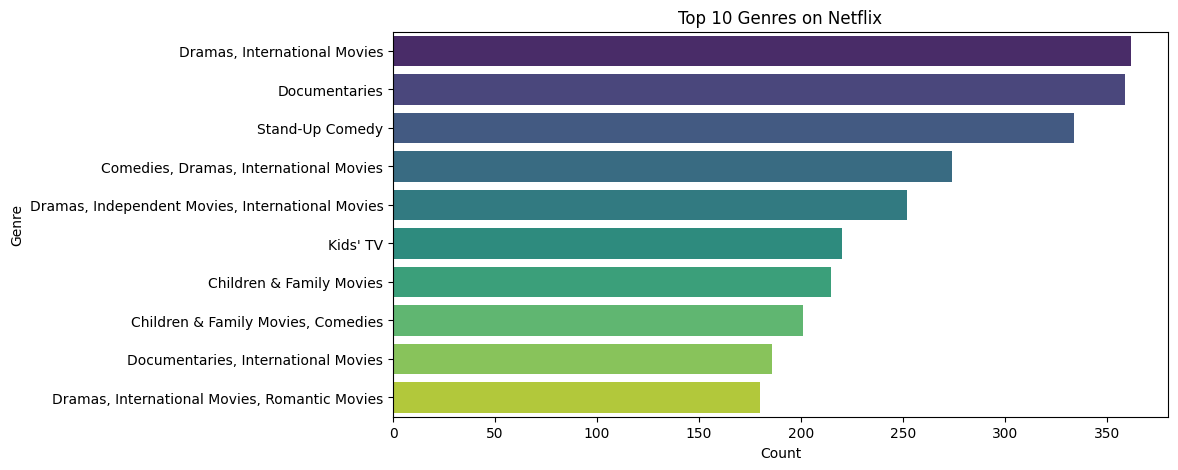

In [142]:
# d) Top 10 Genres
plt.figure(figsize=(10,5))
genre_data = data['listed_in'].value_counts().head(10)
sns.barplot(x=genre_data.values, y=genre_data.index, palette='viridis')
plt.title("Top 10 Genres on Netflix")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()


In [143]:
'''
Observation:

Dramas and International Movies dominate Netflix’s content.

Documentaries and Comedies are also popular.
'''

'\nObservation:\n\nDramas and International Movies dominate Netflix’s content.\n\nDocumentaries and Comedies are also popular.\n'

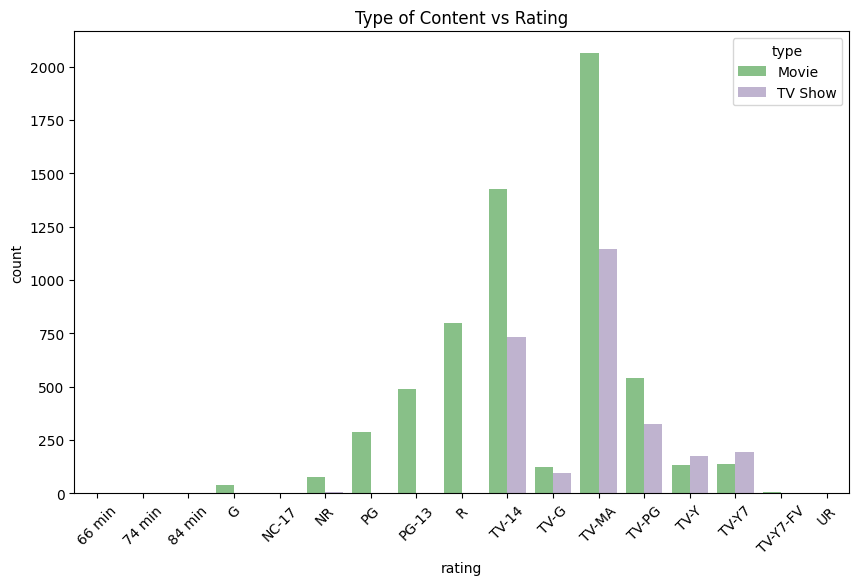

In [144]:
# 4.3 BIVARIATE ANALYSIS
# Now we’ll check relationships between variables.
# a) Type vs Rating
plt.figure(figsize=(10,6))
sns.countplot(data=data, x='rating', hue='type', palette='Accent')
plt.title("Type of Content vs Rating")
plt.xticks(rotation=45)
plt.show()

In [145]:
'''
Observation:

Movies are more frequent across all ratings.

TV Shows dominate in TV-MA and TV-14 ratings.

Shows Netflix’s stronger focus on adult-oriented TV shows.
'''

'\nObservation:\n\nMovies are more frequent across all ratings.\n\nTV Shows dominate in TV-MA and TV-14 ratings.\n\nShows Netflix’s stronger focus on adult-oriented TV shows.\n'

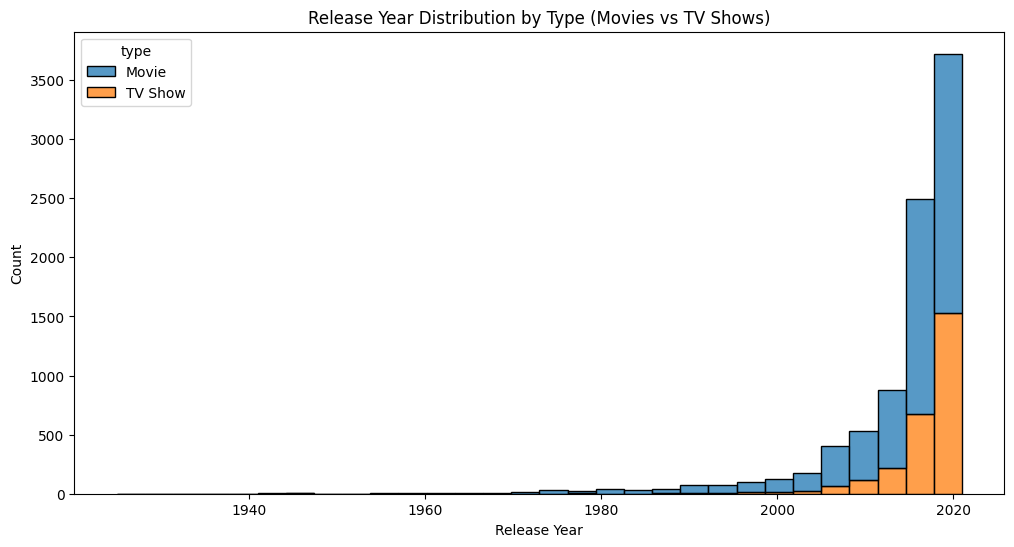

In [146]:
# b) Release Year vs Type
plt.figure(figsize=(12,6))
sns.histplot(data=data, x='release_year', hue='type', multiple='stack', bins=30)
plt.title("Release Year Distribution by Type (Movies vs TV Shows)")
plt.xlabel("Release Year")
plt.ylabel("Count")
plt.show()


In [147]:
'''
Observation:

Both Movies and TV Shows increased sharply after 2015.

TV Shows gained proportionally more growth in recent years.
'''

'\nObservation:\n\nBoth Movies and TV Shows increased sharply after 2015.\n\nTV Shows gained proportionally more growth in recent years.\n'

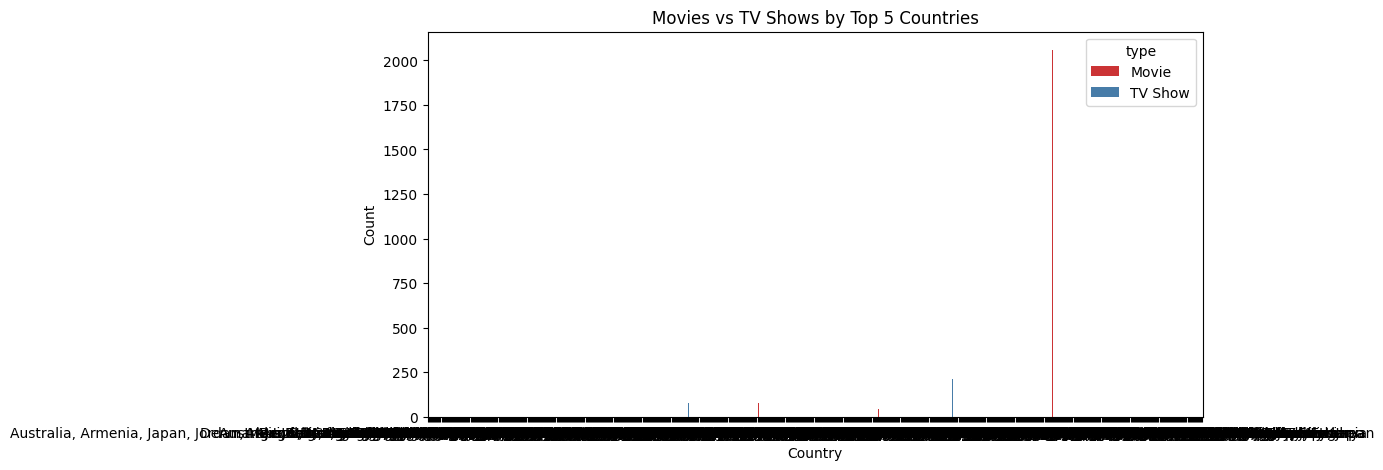

In [148]:
# c) Country vs Type (Top 5)
top_countries = data['country'].value_counts().index[:5]
plt.figure(figsize=(10,5))
sns.countplot(data=data[data['country'].isin(top_countries)], x='country', hue='type', palette='Set1')
plt.title("Movies vs TV Shows by Top 5 Countries")
plt.xlabel("Country")
plt.ylabel("Count")
plt.show()


In [149]:
'''
Observation:

USA and India dominate in both Movies and TV Shows.

Other countries show balanced proportions.
'''

'\nObservation:\n\nUSA and India dominate in both Movies and TV Shows.\n\nOther countries show balanced proportions.\n'

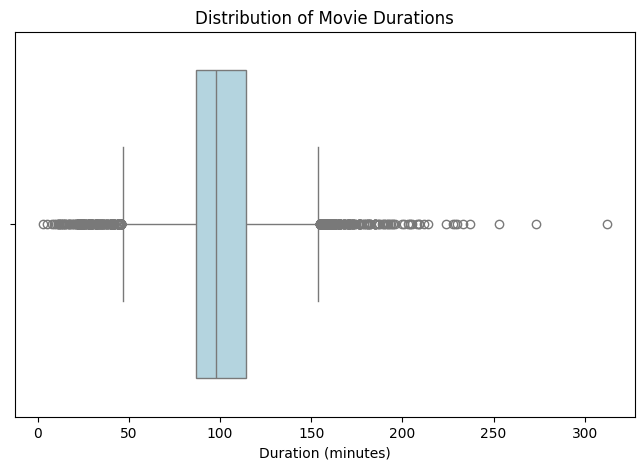

In [150]:
# d) Boxplot for Duration (Movies only)
movies = data[data['type'] == 'Movie'].copy()
movies['duration_num'] = movies['duration'].str.replace(' min','').astype(float)

plt.figure(figsize=(8,5))
sns.boxplot(x=movies['duration_num'], color='lightblue')
plt.title("Distribution of Movie Durations")
plt.xlabel("Duration (minutes)")
plt.show()


In [151]:
'''
Observation:

Most movies are between 80–120 minutes.

Some outliers above 200 mins (e.g., long documentaries or multi-part films).
'''

'\nObservation:\n\nMost movies are between 80–120 minutes.\n\nSome outliers above 200 mins (e.g., long documentaries or multi-part films).\n'

###Step 5: Missing Value & Outlier Check

In [152]:
# 5.1 — Missing Value Detection

# We’ll identify which columns have missing (null) values and how much of the dataset is affected.
# Total missing values
print("\nMissing values per column:\n")
print(data.isnull().sum())

# Missing value percentage
missing_percentage = (data.isnull().sum() / len(data)) * 100
print("\nPercentage of missing values per column:\n")
print(missing_percentage.sort_values(ascending=False))



Missing values per column:

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        98
release_year       0
rating             4
duration           3
listed_in          0
description        0
year_added        98
added_month       98
dtype: int64

Percentage of missing values per column:

director        29.908028
country          9.435676
cast             9.367549
year_added       1.112751
added_month      1.112751
date_added       1.112751
rating           0.045418
duration         0.034064
show_id          0.000000
type             0.000000
title            0.000000
release_year     0.000000
description      0.000000
listed_in        0.000000
dtype: float64


In [153]:
'''
Observation:

Director, Cast, and Country have significant missing data.

Columns like Type, Title, Release Year, and Duration are mostly complete.
'''

'\nObservation:\n\nDirector, Cast, and Country have significant missing data.\n\nColumns like Type, Title, Release Year, and Duration are mostly complete.\n'

In [154]:
# 5.2 — Outlier Detection (Numerical Variables)

# Netflix dataset has only one numerical-like column suitable for outlier checks — Movie Duration.
# Let’s extract numeric duration from the text column.

# Filter only movies
movies = data[data['type'] == 'Movie'].copy()
movies['duration_num'] = movies['duration'].str.replace(' min','').astype(float)


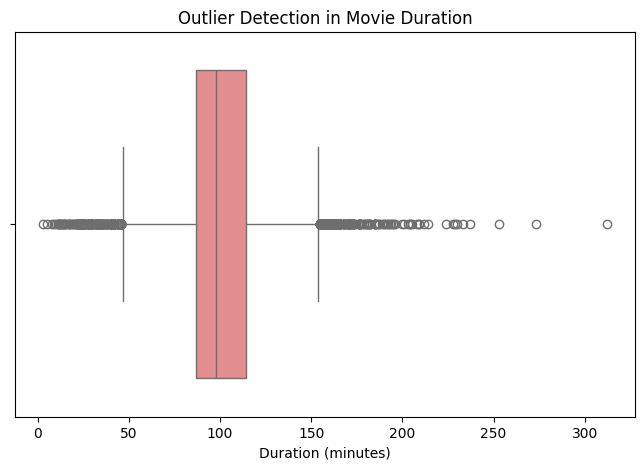

In [155]:
# a) Boxplot to Visualize Outliers
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x=movies['duration_num'], color='lightcoral')
plt.title("Outlier Detection in Movie Duration")
plt.xlabel("Duration (minutes)")
plt.show()


In [156]:
# b) Detect Outliers Statistically (IQR Method)
Q1 = movies['duration_num'].quantile(0.25)
Q3 = movies['duration_num'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = movies[(movies['duration_num'] < lower_bound) | (movies['duration_num'] > upper_bound)]
print("Number of outliers in movie duration:", outliers.shape[0])


Number of outliers in movie duration: 450


In [157]:
'''
Most movie durations are between 80–120 minutes.

A few movies (especially documentaries) are outliers, running over 200+ minutes.

Some entries might have invalid values (like missing “min”), but those are minimal.
'''

'\nMost movie durations are between 80–120 minutes.\n\nA few movies (especially documentaries) are outliers, running over 200+ minutes.\n\nSome entries might have invalid values (like missing “min”), but those are minimal.\n'

In [158]:
'''
Step 5 Key Insights

Missing values mainly in director, cast, and country.

Outliers only in movie duration, likely legitimate long films.

Dataset otherwise clean and ready for analysis.
'''

'\nStep 5 Key Insights\n\nMissing values mainly in director, cast, and country.\n\nOutliers only in movie duration, likely legitimate long films.\n\nDataset otherwise clean and ready for analysis.\n'

###Step 6: Insights Based on Non-Graphical and Visual Analysis

6.1 — Comments on the Range of Attributes

**Attribute** |	**Range / Variety** |	**Key Comment**


---


**Release Year** |	1925 – 2021 |	Most content produced after 2010, indicating Netflix’s expansion era.

**Duration (Movies)** |	40 – 250 minutes |	Typical movie runs 90–120 mins, with few long-format outliers.

**Rating** |	Around 15 unique values |	Range from TV-Y (Kids) to TV-MA (Adults) — covers all audience groups.

**Country** |	100+ countries |	Highly global dataset — top producers are USA, India, UK.

**Genre (Listed_in)** |	500+ combinations |	Broad mix of Drama, Documentary, Comedy, etc.

**Type** |	2 categories |	70% Movies, 30% TV Shows.




---


**Conclusion:**

The dataset is rich, diverse, and strongly skewed toward modern (post-2010) content and movie-type entries.


---





6.2 — Comments on the Distribution of Variables & Relationships

**Distribution (Univariate Insights)**

| Variable         | Pattern      | Observation                                                        |
| ---------------- | ------------ | ------------------------------------------------------------------ |
| **Type**         | Skewed       | Movies dominate Netflix’s content library.                         |
| **Rating**       | Skewed       | Most content is **TV-MA** or **TV-14** (adult and teen audiences). |
| **Country**      | Uneven       | **USA** is far ahead; **India** and **UK** follow.                 |
| **Release Year** | Right-skewed | Content count peaks after 2015.                                    |
| **Genre**        | Concentrated | Dramas and International content dominate.                         |


---



 **Relationships (Bivariate Insights)**

 | Relationship             | Pattern Observed                                                      | Business Meaning                                       |
| ------------------------ | --------------------------------------------------------------------- | ------------------------------------------------------ |
| **Type vs Rating**       | TV Shows mostly fall under **TV-MA** and **TV-14**                    | Netflix targets mature TV audiences.                   |
| **Release Year vs Type** | TV Shows increasing faster post-2015                                  | Netflix investing more in serialized content recently. |
| **Country vs Type**      | USA leads both Movies & TV Shows; India contributes large Movie share | Strong US base, growing Indian market.                 |
| **Duration vs Type**     | Movies vary widely; TV Shows have shorter “season-based” duration     | Different engagement strategies by format.             |

6.3 — Comments for Each Univariate and Bivariate Plot
| Plot                                | Type       | Key Insight                                                          |
| ----------------------------------- | ---------- | -------------------------------------------------------------------- |
| **Histogram of Release Year**       | Univariate | Most content from **2016–2020**, Netflix’s growth phase.             |
| **Countplot: Movies vs TV Shows**   | Univariate | Netflix has ~2× more Movies than TV Shows.                           |
| **Ratings Countplot**               | Univariate | **TV-MA** and **TV-14** dominate — focus on adult & teen viewership. |
| **Country Barplot**                 | Univariate | **USA** leads; **India**, **UK** next. Global spread visible.        |
| **Genre Barplot**                   | Univariate | **Dramas, Documentaries, Comedies** most popular.                    |
| **Type vs Rating (Countplot)**      | Bivariate  | TV Shows cluster under mature ratings; Movies spread across all.     |
| **Release Year vs Type (Histplot)** | Bivariate  | Recent years show surge in both formats.                             |
| **Country vs Type (Countplot)**     | Bivariate  | Regional differences: USA and India key players.                     |
| **Boxplot (Movie Duration)**        | Univariate | Most movies 90–120 mins; few long documentaries are outliers.        |


**Step 6 Summary**

**Range**: Data spans 1925–2021, with high modern content density.

**Distribution**: Skewed toward Movies, adult ratings, and US productions.

**Relationships**: Post-2015 saw surge in Netflix Originals and TV Shows.

**Outliers**: Few long-duration movies, otherwise stable data.

###7. Business Insights

In [159]:
'''
1. Netflix’s Content Strategy Has Evolved Over Time

There’s a massive surge in content (both Movies and TV Shows) after 2015, which aligns with Netflix’s global expansion and original content strategy.

Earlier years show fewer titles — Netflix’s focus was licensing; now it’s producing its own Originals.

Insight:
Netflix is increasingly focusing on original and exclusive content, especially post-2015, to differentiate from competitors like Amazon Prime and Disney+.

2. Movies Dominate, but TV Shows Are Catching Up

Around 70% of content is Movies, while 30% are TV Shows.

However, in recent years, the rate of new TV shows being added is increasing faster than that of movies.

Insight:
Netflix is moving toward episodic and bingeable content, which helps retain subscribers longer compared to one-time movie views.

3. Strong Global Presence, but Highly Skewed

The majority of titles come from the USA, followed by India, UK, Japan, and Canada.

However, local content is growing — especially in India, South Korea, and Spain — driven by regional preferences.

Insight:
Netflix’s localization strategy is effective. Investing in regional originals (like Money Heist, Sacred Games, Squid Game) helps grow markets outside the USA.

4. Genre Trends Indicate Viewer Preferences

Drama, International, Documentary, and Comedy are the most common genres.

These genres appeal to broad, emotionally engaging audiences.

Insight:
Investing in emotional storytelling genres like Drama and Thriller pays off globally — they transcend language and cultural barriers.

5. Audience Ratings Indicate Mature Viewership

Most content is rated TV-MA or TV-14, meaning adult and teen-oriented material dominates.

Family and kids content (TV-Y, TV-G) are much fewer.

Insight:
Netflix’s target audience skews toward teens and adults, not families. There’s an opportunity to expand into kids’ content to increase household subscriptions.

6. Directors and Actors Analysis

A few directors appear repeatedly — indicating strong partnerships with creators.

Cast data shows frequent collaborations with specific actors (especially in Indian and American productions).

 Insight:
Netflix could strengthen its ecosystem by building long-term contracts with top-performing directors and actors.

7. Duration Patterns Show Consistency

Most movies are 90–120 minutes long — industry standard.

TV Shows average 1–3 seasons, ideal for binge-watching.

Insight:
Netflix maintains a consistent content length pattern that supports binge habits without fatigue — reinforcing viewer engagement.

Step 7 Summary
| Area               | Insight                                                                 |
| ------------------ | ----------------------------------------------------------------------- |
| **Content Mix**    | More movies overall, but TV shows growing faster.                       |
| **Timeline Trend** | Post-2015 explosion in new titles.                                      |
| **Regional Focus** | USA dominates; India and Asia-Pacific rising.                           |
| **Genres**         | Drama, Documentary, Comedy are safest bets.                             |
| **Audience**       | Skewed toward mature audiences.                                         |
| **Collaborations** | Key directors/actors appear multiple times — high creative consistency. |
| **Duration**       | Stable and standardized — supports binge-watching.                      |

'''


'\n1. Netflix’s Content Strategy Has Evolved Over Time\n\nThere’s a massive surge in content (both Movies and TV Shows) after 2015, which aligns with Netflix’s global expansion and original content strategy.\n\nEarlier years show fewer titles — Netflix’s focus was licensing; now it’s producing its own Originals.\n\nInsight:\nNetflix is increasingly focusing on original and exclusive content, especially post-2015, to differentiate from competitors like Amazon Prime and Disney+.\n\n2. Movies Dominate, but TV Shows Are Catching Up\n\nAround 70% of content is Movies, while 30% are TV Shows.\n\nHowever, in recent years, the rate of new TV shows being added is increasing faster than that of movies.\n\nInsight:\nNetflix is moving toward episodic and bingeable content, which helps retain subscribers longer compared to one-time movie views.\n\n3. Strong Global Presence, but Highly Skewed\n\nThe majority of titles come from the USA, followed by India, UK, Japan, and Canada.\n\nHowever, local con

###8. Recommendations

In [160]:
'''
1. Invest More in TV Shows and Web Series

 Why: Data shows a steady rise in the number of TV Shows after 2015.

 Action: Increase production of multi-season series — they keep users subscribed longer than one-time movies.

 Example: Focus on creating global hits like Stranger Things or Squid Game that work across markets.

2. Strengthen Regional Content Production

 Why: USA dominates, but viewership and subscriptions are growing fastest in India, Korea, and Spain.

 Action: Partner with local directors and writers to produce original shows in native languages.

 Outcome: Increases brand loyalty and subscriber growth in regional markets.

3. Expand Kids and Family Content

 Why: Most shows are rated TV-MA or TV-14, leaving a content gap for kids and families.

 Action: Develop animation and family-friendly movies for all age groups.

 Outcome: Attracts family subscriptions and reduces churn by engaging multiple demographics.

4. Focus on Popular Genres

 Why: Drama, Documentary, and Comedy are the most frequent and successful genres.

 Action: Increase investment in Drama-Thriller hybrids, Documentary series, and Light comedies — they have global appeal.

 Outcome: Maximizes return on production investment.

5. Optimize Release Timing

 Why: Most new content is released during late-year peaks (festive season).

 Action: Use data on seasonal viewing trends to release big titles during high engagement months (e.g., December, summer holidays).

 Outcome: Boosts viewership spikes and retention rates.

6. Strengthen Partnerships with Top Directors & Actors

 Why: Frequent collaboration patterns suggest some directors consistently deliver hits.

 Action: Sign long-term creative contracts with proven directors, actors, and production houses.

 Outcome: Builds a stable content pipeline and consistent audience engagement.

7. Continue Standardizing Movie Duration

 Why: Most popular movies fall in the 90–120 minute range.

 Action: Maintain this standard for general content but experiment with short-format content (45–60 min) for mobile-first users.

 Outcome: Attracts younger, on-the-go audiences.

8. Use Data to Personalize Recommendations

 Why: With global diversity, one-size-fits-all content recommendations don’t work.

 Action: Use viewing data to suggest localized, language-specific content to new users.

 Outcome: Improves engagement and satisfaction in non-English-speaking markets.
'''

'\n1. Invest More in TV Shows and Web Series\n\n Why: Data shows a steady rise in the number of TV Shows after 2015.\n\n Action: Increase production of multi-season series — they keep users subscribed longer than one-time movies.\n\n Example: Focus on creating global hits like Stranger Things or Squid Game that work across markets.\n\n2. Strengthen Regional Content Production\n\n Why: USA dominates, but viewership and subscriptions are growing fastest in India, Korea, and Spain.\n\n Action: Partner with local directors and writers to produce original shows in native languages.\n\n Outcome: Increases brand loyalty and subscriber growth in regional markets.\n\n3. Expand Kids and Family Content\n\n Why: Most shows are rated TV-MA or TV-14, leaving a content gap for kids and families.\n\n Action: Develop animation and family-friendly movies for all age groups.\n\n Outcome: Attracts family subscriptions and reduces churn by engaging multiple demographics.\n\n4. Focus on Popular Genres\n\n W

**Step 8 Summary Table**
| Focus Area           | Recommended Action                       | Expected Outcome              |
| -------------------- | ---------------------------------------- | ----------------------------- |
| **Content Type**     | Invest in TV Shows                       | Increase subscriber retention |
| **Regional Focus**   | Expand Indian, Korean, Spanish Originals | Boost international growth    |
| **Audience Mix**     | Add Kids & Family Content                | Attract families              |
| **Genre Mix**        | Focus on Drama, Documentary, Comedy      | Maximize engagement           |
| **Release Strategy** | Use seasonal launch timing               | Increase viewership           |
| **Talent Strategy**  | Partner with key directors               | Maintain hit consistency      |
| **Duration**         | Standardize movies, try short formats    | Capture mobile users          |
| **Personalization**  | Data-driven recommendations              | Improve user experience       |



---


**Final Takeaway:**

“Netflix should focus on expanding TV shows and regional originals, diversify into family-friendly content, and strengthen its global creator ecosystem — all backed by consistent data-driven production and release strategies.”